**Error Analysis**

In [1]:
# import libraries

import earthaccess
import xarray as xr
import dask
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.feature as cfeature
from rasterio import features
from scipy.ndimage import convolve
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# colormap for plotting sea ice throughout rest of project

cmap = plt.get_cmap("Blues").copy()
cmap.set_bad(color='lightgray')

# authenticate NASA earth access

auth = earthaccess.login(strategy='interactive', persist = True)

In [ ]:
# search NASA database

results = earthaccess.search_data(
    short_name='NSIDC-0051',
    temporal=('1990-01-01', '2025-10-01'),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

print(f"we found {len(results)} results")

we found 63 results


In [3]:
# stream files into xarray

files = earthaccess.open(results)
ds = xr.open_mfdataset(files, parallel=True, combine='by_coords')

# print datasets
ds

QUEUEING TASKS | :   0%|          | 0/63 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/63 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/63 [00:00<?, ?it/s]

<xarray.Dataset> Size: 66MB
Dimensions:     (time: 61, y: 448, x: 304)
Coordinates:
  * x           (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y           (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * time        (time) datetime64[ns] 488B 2023-04-01 2023-04-02 ... 2023-05-31
Data variables:
    crs         (time) |S1 61B b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    F17_ICECON  (time, y, x) float64 66MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes: (12/49)
    title:                     Sea Ice Concentrations from Nimbus-7 SMMR and ...
    summary:                   This data set is generated from brightness tem...
    id:                        10.5067/MPYG15WAA4WX
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/MPYG15WAA4WX
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    Polar stereographic brightness temperatures fr...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounder
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...

In [4]:
# read in land file from geopandas

land = gpd.read_file("../data/ne_10m_land/ne_10m_land.shp")
land = land.to_crs(epsg=3411)

# create affine transform and make sure arctic is not upside down

dx = float(ds.x.diff('x').mean())
dy = float(ds.y.diff('y').mean())
x0 = float(ds.x.min())
y0 = float(ds.y.max())

transform = [dx, 0, x0, 0, -abs(dy), y0]

# use transform to mask out coastal cells

land_mask = features.rasterize(
    ((geom, 1) for geom in land.geometry),
    out_shape=(ds.sizes['y'], ds.sizes['x']),
    transform=transform,
    fill=0,
    dtype=np.uint8
)

In [5]:
# calculate distance from land using euclidian distance transform

distance_from_land = distance_transform_edt(land_mask == 0)

# convert to xarray.DataArray

distance_xr = xr.DataArray(
    distance_from_land,
    coords={'y': ds.y, 'x': ds.x},
    dims=('y', 'x'),
    name='distance_to_land_cells'
)

# add as data variable in ds

ds['edtl'] = distance_xr

In [6]:
# read in visual data and do some conversions

visual = pd.read_csv("../local data/big_array_coast_cell_smallest.csv")
visual["time"] = pd.to_datetime(visual["Date"], yearfirst = True)
visual.head(10)

,system:index,Cloud cover,Column,Date,Land frac,Ocean frac,Row,SI frac,Scene ID,Snow frac,Sun azimuth,Sun elevation,WRS path,WRS row,total pixels,.geo,time
0,00000000000000000000,0.0,256.0,2023-04-19,0.004014,0.0,47.0,0.0,LC90530142023109LGN00,0.995986,169.913151,35.396205,53.0,14.0,671698,"{""type"":""Polygon"",""coordinates"":[[[-123.381475...",2023-04-19
1,00000000000000000001,0.0,257.0,2023-04-19,0.000000,0.0,47.0,0.0,LC90530142023109LGN00,1.000000,169.913151,35.396205,53.0,14.0,671167,"{""type"":""Polygon"",""coordinates"":[[[-122.868679...",2023-04-19
2,00000000000000000002,0.0,259.0,2023-04-19,0.027171,0.0,47.0,0.0,LC90530142023109LGN00,0.972829,169.913151,35.396205,53.0,14.0,670779,"{""type"":""Polygon"",""coordinates"":[[[-121.849051...",2023-04-19
3,00000000000000000003,0.0,256.0,2023-04-19,0.002093,0.0,48.0,0.0,LC90530142023109LGN00,0.997907,169.913151,35.396205,53.0,14.0,672582,"{""type"":""Polygon"",""coordinates"":[[[-123.274888...",2023-04-19
4,00000000000000000004,0.0,257.0,2023-04-19,0.000000,0.0,48.0,0.0,LC90530142023109LGN00,1.000000,169.913151,35.396205,53.0,14.0,672346,"{""type"":""Polygon"",""coordinates"":[[[-122.757668...",2023-04-19
5,00000000000000000005,0.0,259.0,2023-04-19,0.072040,0.0,48.0,0.0,LC90530142023109LGN00,0.927960,169.913151,35.396205,53.0,14.0,671862,"{""type"":""Polygon"",""coordinates"":[[[-121.729356...",2023-04-19
6,00000000000000000006,0.0,260.0,2023-04-19,0.024412,0.0,48.0,0.0,LC90530142023109LGN00,0.975588,169.913151,35.396205,53.0,14.0,671675,"{""type"":""Polygon"",""coordinates"":[[[-121.218402...",2023-04-19
7,00000000000000000007,0.0,261.0,2023-04-19,0.006646,0.0,48.0,0.0,LC90530142023109LGN00,0.993354,169.913151,35.396205,53.0,14.0,646279,"{""type"":""Polygon"",""coordinates"":[[[-120.709674...",2023-04-19
8,00000000000000000008,0.0,262.0,2023-03-13,0.231928,0.0,48.0,0.0,LC90500152023072LGN00,0.768072,167.020963,22.380426,50.0,15.0,392932,"{""type"":""Polygon"",""coordinates"":[[[-119.842207...",2023-03-13
9,00000000000000000009,0.0,252.0,2023-04-26,0.011049,0.0,49.0,0.0,LC90540142023116LGN00,0.988951,170.070773,37.748011,54.0,14.0,674888,"{""type"":""Polygon"",""coordinates"":[[[-125.272421...",2023-04-26


In [7]:
# convert rows and columns into lats and lons

row_to_lat = dict(enumerate(ds['x'].values))
col_to_lon = dict(enumerate(ds['y'].values))
visual['x'] = visual['Row'].map(row_to_lat)
visual['y'] = visual['Column'].map(col_to_lon)

# convert pandas dataframe of visual things into chunked xarray dataset on time, lat, and long

da_sparse = visual.set_index(['time', 'y', 'x']).to_xarray()
da_full = da_sparse.reindex_like(ds, method=None)
da_full = da_full.chunk({'time': 2})
da_full

# assign visual data to the NASA team dataset and sanity check plot

ds = ds.assign(**{'SI_frac': da_full['SI frac']})

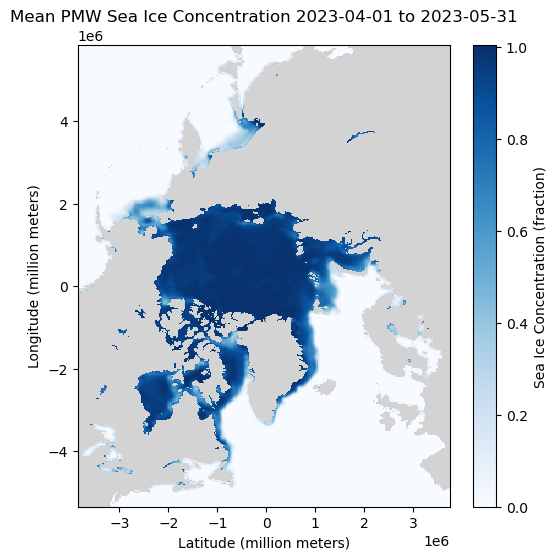

In [20]:
# sanity check one

ds_subset = ds.where(ds.F17_ICECON < 1.01)
ax = ds_subset.F17_ICECON.mean(dim='time').plot(
    cmap=cmap,
    cbar_kwargs={'label': 'Sea Ice Concentration (fraction)'},
    figsize=(6,6)
)

plt.title("Mean PMW Sea Ice Concentration 2023-04-01 to 2023-05-31")
plt.xlabel("Latitude (million meters)")
plt.ylabel("Longitude (million meters)")
plt.show()

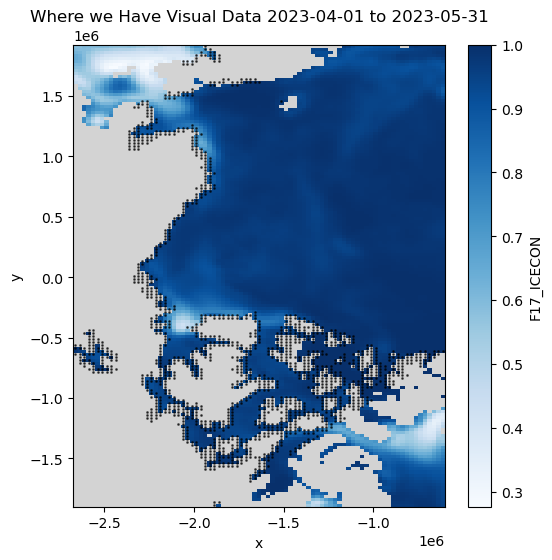

In [9]:
# sanity check two

x_min, x_max = visual['x'].min(), visual['x'].max()
y_min, y_max = visual['y'].min(), visual['y'].max()

ds_subset = ds.sel(x=slice(x_min, x_max), y=slice(y_max, y_min)).where(ds.F17_ICECON < 1.01)
ax = ds_subset.F17_ICECON.mean(dim='time').plot(
    cmap=cmap,
    figsize=(6,6)
)

plt.scatter(
    visual['x'],
    visual['y'],
    color='black',
    s=1,
    alpha=0.6
)
plt.title("Where we Have Visual Data 2023-04-01 to 2023-05-31")
plt.show()

In [10]:
# data cleaning

condition = ((ds.SI_frac.notnull()) & (ds.F17_ICECON < 1.0))
ds_clean = ds.where(condition, other=np.nan).compute()

df = ds_clean.to_dataframe().reset_index()
df

,time,y,x,crs,F17_ICECON,edtl,SI_frac
0,2023-04-01,5837500.0,-3837500.0,NaN,NaN,NaN,NaN
1,2023-04-01,5837500.0,-3812500.0,NaN,NaN,NaN,NaN
2,2023-04-01,5837500.0,-3787500.0,NaN,NaN,NaN,NaN
3,2023-04-01,5837500.0,-3762500.0,NaN,NaN,NaN,NaN
4,2023-04-01,5837500.0,-3737500.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
8307707,2023-05-31,-5337500.0,3637500.0,NaN,NaN,NaN,NaN
8307708,2023-05-31,-5337500.0,3662500.0,NaN,NaN,NaN,NaN
8307709,2023-05-31,-5337500.0,3687500.0,NaN,NaN,NaN,NaN
8307710,2023-05-31,-5337500.0,3712500.0,NaN,NaN,NaN,NaN


In [11]:
# calculate error

error = ((ds_clean['F17_ICECON'] - ds_clean['SI_frac']))
error_avg = error.mean(dim=['time', 'x', 'y'], skipna=True)
print('Simple error is', error_avg.compute().item())

Simple error is 0.2244625822723628


In [12]:
# dependancies
#   – sort dataset see if there are differences (how much land, weather, snow cover, clouds, sun elevation)
#   – look at date but not enough dates in sample data
#   – regression, plotting, divide into populations, light gradient boosting?

In [13]:
# clean that table
# there are lots of 1.012 and 1.016 which is obviously impossible but look in NSIDC docs it means something
# calculate error with a sign